# Bank marketing Analysis

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kendalltau
import pickle
import plotly.express  as px 
import tensorflow as tf
import glob
import os


# preprocessing
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer , OutlierTrimmer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#Untuk mengabaikan fitur peringatan
import warnings
warnings.filterwarnings('ignore')

print("Import Berhasil")


Import Berhasil


In [2]:
# Load dataset
df = pd.read_csv('bank.csv')


In [3]:
# Melihat beberapa baris pertama
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# Melihat informasi umum tentang dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [6]:
# Mengecek data duplicate 
df.duplicated().sum()


0

In [7]:
# Handling Missing Value
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

- Tidak ada missing value.

# Analisis Univariate
* Analisis Univariate adalah analisis satu variabel pada satu waktu. Di sini, kita akan menganalisis distribusi dan karakteristik dari masing-masing variabel.


 Distribusi Variabel Numerik.

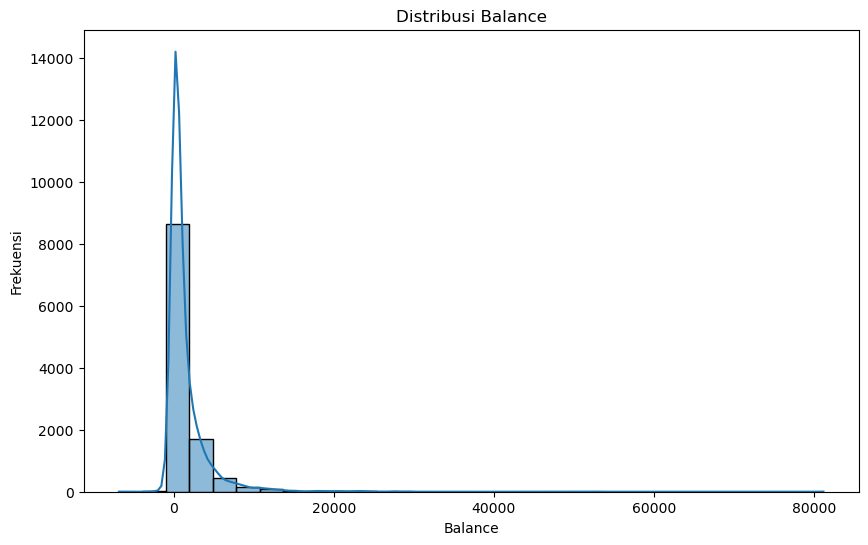

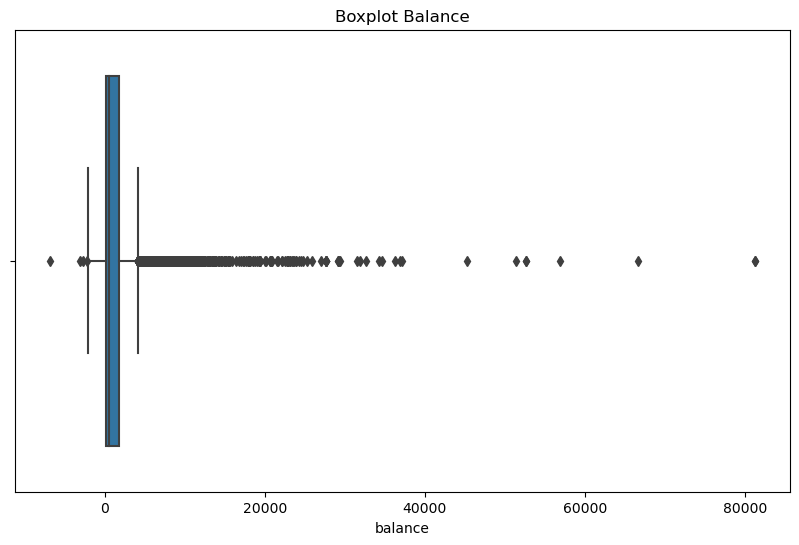

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['balance'], kde=True, bins=30)
plt.title('Distribusi Balance')
plt.xlabel('Balance')
plt.ylabel('Frekuensi')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['balance'])
plt.title('Boxplot Balance')
plt.show()


Kesimpulan:

- Histogram menunjukkan bahwa sebagian besar nasabah memiliki saldo di bawah beberapa ribu unit (tergantung mata uang).
- Boxplot menunjukkan ada beberapa outlier (saldo sangat tinggi) yang mungkin perlu dianalisis lebih lanjut, karena mereka mungkin mempengaruhi hasil model nantinya.

Distribusi Job.

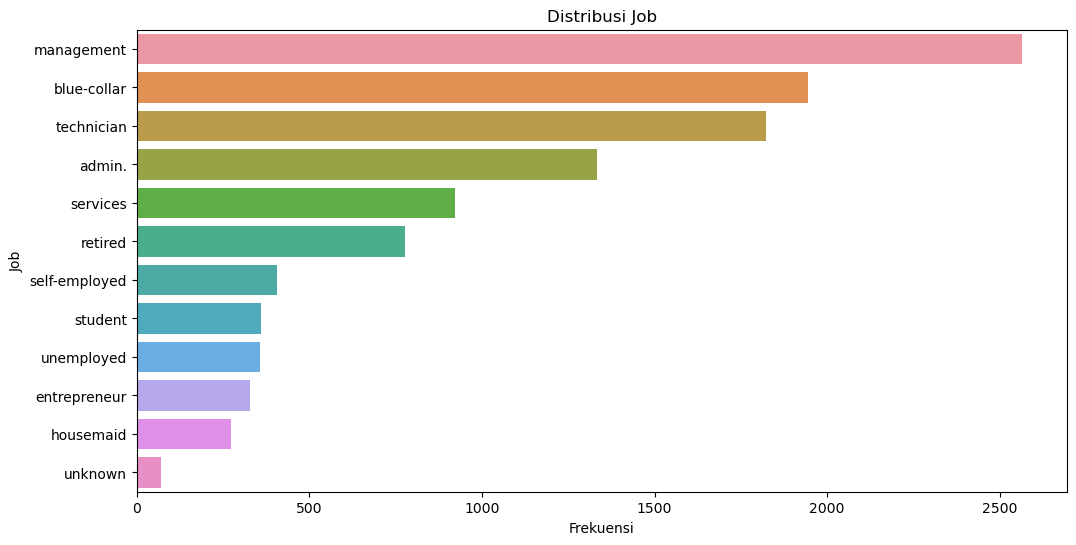

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(y=df['job'], order=df['job'].value_counts().index)
plt.title('Distribusi Job')
plt.xlabel('Frekuensi')
plt.ylabel('Job')
plt.show()


Kesimpulan:

- Mayoritas nasabah bekerja sebagai management, blue-collar, dan technician.
- Ini bisa memberikan insight tentang kelompok pekerjaan mana yang lebih sering menggunakan layanan bank tertentu.

# Analisis Bivariate
* Analisis Bivariate adalah analisis hubungan antara dua variabel. Di sini, kita akan melihat bagaimana setiap variabel berhubungan dengan variabel target kita, yaitu 'deposit'.

Korelasi Antar Variabel Numerik.

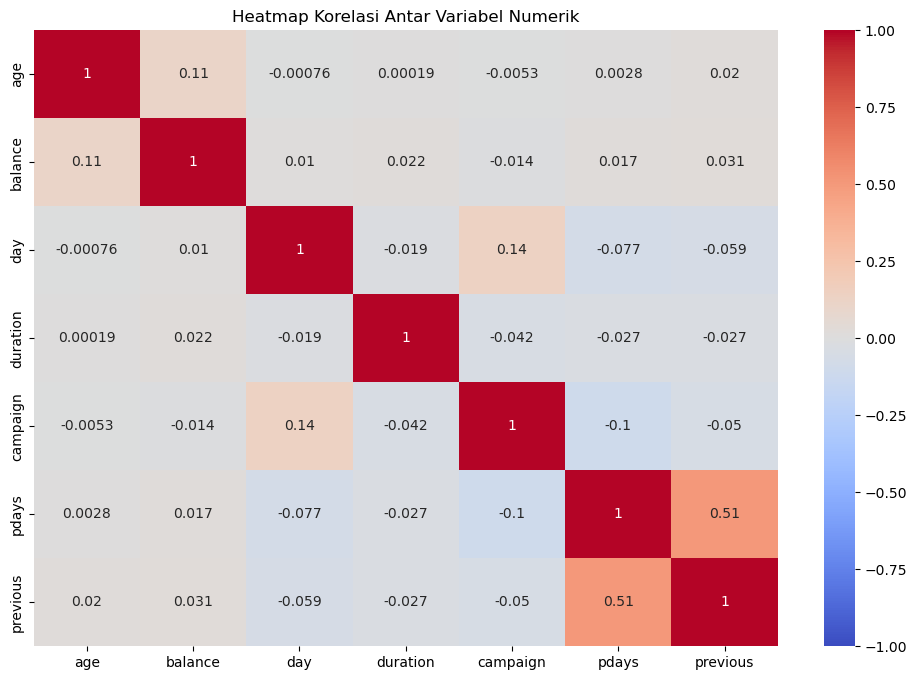

In [11]:
# Pilih hanya kolom numerik
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Hitung korelasi
plt.figure(figsize=(12, 8))
correlation = numerical_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap Korelasi Antar Variabel Numerik')
plt.show()


Boxplot untuk  memahami distribusi variabel deposit dan balance.

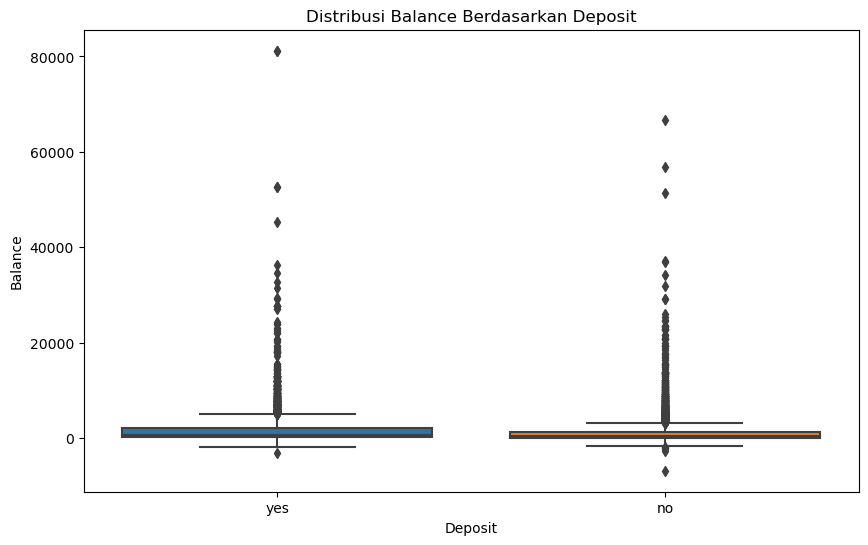

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='deposit', y='balance', data=df)
plt.title('Distribusi Balance Berdasarkan Deposit')
plt.xlabel('Deposit')
plt.ylabel('Balance')
plt.show()


Kesimpulan:

- Boxplot ini menunjukkan bagaimana distribusi balance berbeda antara nasabah yang membuka deposito (yes) dan yang tidak (no).
- Jika balance untuk yes secara signifikan lebih tinggi, ini menunjukkan bahwa nasabah dengan saldo lebih tinggi cenderung lebih mungkin untuk membuka deposito.

Violin plot memberikan informasi tentang distribusi dan kepadatan data, mirip dengan boxplot tapi lebih detail. Ini bisa digunakan untuk variabel seperti duration.

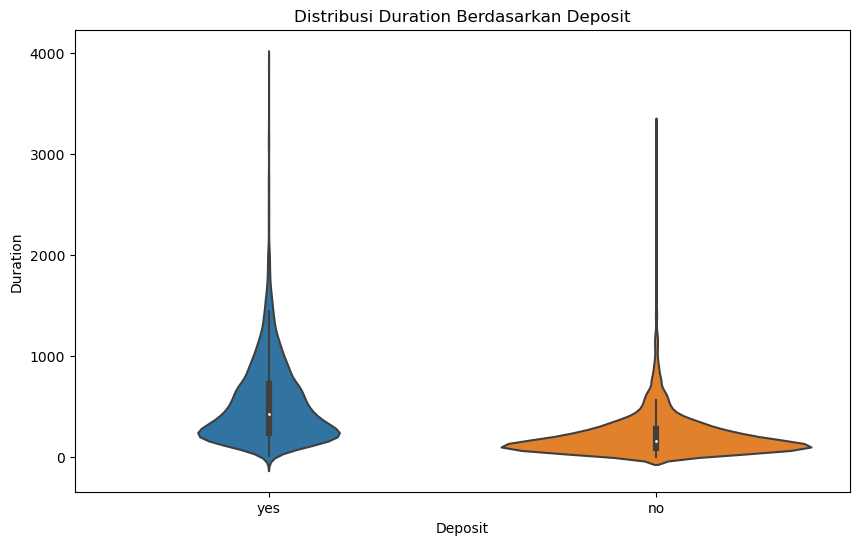

In [14]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='deposit', y='duration', data=df)
plt.title('Distribusi Duration Berdasarkan Deposit')
plt.xlabel('Deposit')
plt.ylabel('Duration')
plt.show()


Kesimpulan:

- Violin plot ini menunjukkan distribusi duration (lama panggilan) antara mereka yang membuka deposito dan yang tidak.
- Jika durasi lebih panjang lebih sering terkait dengan deposito, ini bisa menunjukkan bahwa panggilan yang lebih lama cenderung lebih efektif dalam mengonversi nasabah.

Bar plot untuk melihat bagaimana variabel kategorikal seperti job berhubungan dengan deposit.

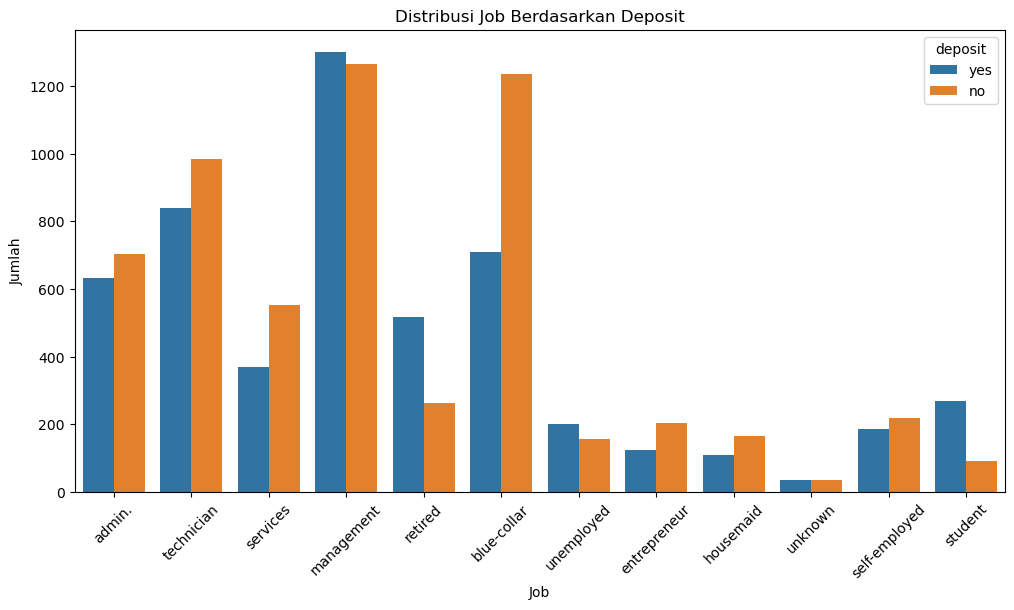

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(x='job', hue='deposit', data=df)
plt.title('Distribusi Job Berdasarkan Deposit')
plt.xlabel('Job')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()


Kesimpulan:

- Bar plot ini menunjukkan bagaimana pekerjaan (job) berbeda mempengaruhi kemungkinan nasabah membuka deposito (yes) atau tidak (no).
- Jika ada pekerjaan tertentu yang memiliki lebih banyak yes, ini bisa menjadi target potensial untuk kampanye deposito.

## Kesimpulan Visualisasi
Setelah melakukan analisis di atas, Anda bisa menarik kesimpulan tentang faktor-faktor yang paling mempengaruhi keputusan nasabah untuk membuka deposito berjangka. Misalnya:

- Nasabah dengan saldo tinggi (balance) lebih mungkin untuk membuka deposito.
- Pekerjaan tertentu (job) seperti management memiliki tingkat konversi deposito yang lebih tinggi.
- Durasi panggilan (duration) yang lebih lama tampaknya meningkatkan kemungkinan keberhasilan dalam membuka deposito.